# Multiple Observation SocialDilemma

> Class for a symmetric two-agent stateless social dilemma environment

Typical examples are the *Prisoner's Dilemma*, *Stag Hunt* game, and the game of *chicken*/*snowdrift*/*hawk-dove*.

In [33]:
#| default_exp Environments/MultipleObsSocialDilemma

In [34]:
#| hide
# Imports for the nbdev development environment
from nbdev.showdoc import *

In [35]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
#| export
from pyCRLD.Environments.Base import ebase

from fastcore.utils import *
from fastcore.test import *

from pyCRLD.Environments.HeterogeneousObservationsEnv import HeterogeneousObservationsEnv

import numpy as np

In [12]:
#| export
class MultipleObsSocialDilemma(HeterogeneousObservationsEnv):
    """
    Symmetric 2-agent 2-action Social Dilemma Matrix Game.
    """
    def __init__(self,
                 rewards,  # rewards of mutual cooperation
                 temptations,  # temptations of unilateral defection
                 suckers_payoffs,  # sucker's payoff of unilateral cooperation
                 punishments,  # punishment of mutual defection
                 pC=0.5,
                 observation_opacity=None):

        # Normalize inputs to be lists of length 2
        self.rewards = [rewards, rewards] if isinstance(rewards, int) else rewards
        self.temptations = [temptations, temptations] if isinstance(temptations, int) else temptations
        self.suckers_payoffs = [suckers_payoffs, suckers_payoffs] if isinstance(suckers_payoffs, int) else suckers_payoffs
        self.punishments = [punishments, punishments] if isinstance(punishments, int) else punishments

        # Ensuring all are lists of size 2 for consistency
        if not all(len(lst) == 2 for lst in [self.rewards, self.temptations, self.suckers_payoffs, self.punishments]):
            raise ValueError("All parameters must either be a single integer or a list of two integers.")

        # TODO: these variables are expected to be already initialized in the parent class
        # causing a recursive calling and causing the dependency on them to fail
        # therefore we need to initialize them here
        self.n_agents = 2
        self.n_agent_actions = 2
        self.n_states = 2 # TODO: I'm not entirely sure on why we have 2 states here
        
        self.observation_opacity = observation_opacity
        self.pC = pC  # prop. for contract
        # This adds a dynamic aspect to the game where the outcome can also depend on the evolving 
        # relationship state (contract or no contract).
        # In the Uncertain Env. a state is either contracted or not, this indicate whether there is an agreement
        # or alignment between the agents, which could influence their strategic decisions. This state aspect
        # goes beyond the classic IPD setup, where such external conditions or states do not typically change
        # the payoffs directly within a single round.
        self.state = 0 # initial state
        super(MultipleObsSocialDilemma, self).__init__(observation_opacity=observation_opacity)


In [25]:
#| export
@patch
def transition_tensor(self:MultipleObsSocialDilemma):
    """Calculate the Transition Tensor"""
    Tsas = np.ones((2, 2, 2, 2)) * (-1)
    Tsas[:, :, :, 0] = 1 - self.pC
    Tsas[:, :, :, 1] = self.pC
    return Tsas

@patch
def reward_tensor(self:MultipleObsSocialDilemma):
    """Get the Reward Tensor R[i,s,a1,...,aN,s']."""

    R = np.zeros((self.n_agents, self.n_states, self.n_agent_actions, self.n_agent_actions, self.n_states))

    # TODO: the way these arrays are defined is invalid code and I dont want to figure out why

    # TODO: in general i don't understand the construction of these arrays. What does : do anyway?
    # ok so the cmd above creates two arrays (n_agents) of a two dimensional space that is indicating the number
    # of states, for each action an agent can take... So we have one matrix that contains all actions C 
    # and another matrix containing all actions D. So I'm assuming a game can be in either C state or D state?
    # though I thought IPD only had one state '.'. This is where my confusion lies.
    # I also don't fully understand how these arrays are filled. I should print R and check.

    # TODO: I wonder if it's the different values that this reward tensors receive that's messing up
    # my values further on
    
    # set reward matrix for agent 0
    R[0, 0, :, :, 0] = [[self.rewards[0], self.suckers_payoffs[0]],
                        [self.temptations[0], self.punishments[0]]]
    R[1, 0, :, :, 0] = [[self.rewards[0], self.temptations[0]],
                        [self.suckers_payoffs[0], self.punishments[0]]]
    R[:, 0, :, :, 1] = R[:, 0, :, :, 0]

    # set reward matrix for agent 1 in the second state
    R[0, 1, :, :, 1] = [[self.rewards[1], self.suckers_payoffs[1]],
                        [self.temptations[1], self.punishments[1]]]
    R[1, 1, :, :, 1] = [[self.rewards[1], self.temptations[1]],
                        [self.suckers_payoffs[1], self.punishments[1]]]
    R[:, 1, :, :, 0] = R[:, 1, :, :, 1]
    
    return R

@patch
def actions(self:MultipleObsSocialDilemma):
    """The action sets"""
    return [['c', 'd'] for _ in range(self.n_agents)]

@patch
def states(self:MultipleObsSocialDilemma):
    """The states set"""
    return [0, 1], ["no contract", "contract"] # TODO: I don't understand why we use 2 states?

@patch
def id(self:MultipleObsSocialDilemma):
    """
    Returns id string of environment
    """
    # Default
    id = f"{self.__class__.__name__}_"+\
        f"{self.temptations}_{self.rewards}_{self.punishments}_{self.suckers_payoffs}"
    return id

### Example

In [28]:
env_full_obs = MultipleObsSocialDilemma(rewards=1, temptations=2, suckers_payoffs=-1, punishments=0, observation_opacity=[0, 0])

# TODO: if opacity = observation_opacity=[0.7, 0])
# resulting matrix still is 
# array([[[0.5, 0.5],
#         [0.5, 0.5]],

#        [[1. , 0. ],
#         [0. , 1. ]]])
# but it'd be cool if this is percentage of how much an agent can see back in the past or not
# as if it was a percentage... of the amount of things they can see

# TODO: there's another problem
# if opacity = observation_opacity=[0.2, 0])
# the matrix adjusts like this
# array([[[0.8, 0.2],
#         [0.2, 0.8]],

#        [[1. , 0. ],
#         [0. , 1. ]]])
# However, I've just realized this matrix is not about percentages of probabibilities of seeing
# things, but it's the actual seeing. Meaning if they're confused about the environment and have
# partial vision they should have 0.5 everywhere. This should be a simple bug to fix I just have to
# reset the behavior for when it's smaller than 0.5 to be the same for when it's equal to bigger than
# 0.5

for agent  0
confidence is , 0
2 2 2
for agent  1
confidence is , 0
2 2 2


In [29]:
env_full_obs.observations

array([[[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]]])

In [30]:
env_full_obs.rewards

array([[[[[ 1.,  1.],
          [-1., -1.]],

         [[ 2.,  2.],
          [ 0.,  0.]]],


        [[[ 1.,  1.],
          [-1., -1.]],

         [[ 2.,  2.],
          [ 0.,  0.]]]],



       [[[[ 1.,  1.],
          [ 2.,  2.]],

         [[-1., -1.],
          [ 0.,  0.]]],


        [[[ 1.,  1.],
          [ 2.,  2.]],

         [[-1., -1.],
          [ 0.,  0.]]]]])

In [31]:
env_full_obs.observation_labels

[['0', '1'], ['0', '1']]

### Testing MultipleObsSocialDilemma under full homogeneous observability conditions:

In [40]:
from pyCRLD.Agents.POStrategyActorCritic import POstratAC
from pyCRLD.Utils import FlowPlot as fp

# This code is equivalent to the one under EnvUncertainDilemma
env_fullObs = MultipleObsSocialDilemma(rewards=[5, 5], temptations=[6, 2], suckers_payoffs=[-1, -1], punishments=[0, 0], pC=0.5, observation_opacity=[0, 0])
mae_fullObs = POstratAC(env=env_fullObs, learning_rates=0.1, discount_factors=0.9)

for agent  0
confidence is , 0
2 2 2
for agent  1
confidence is , 0
2 2 2


array([<Axes: title={'center': 'Cond. 0'}, xlabel="Agnt 1's prob. for c", ylabel="Agnt 2's prob. for c">,
       <Axes: title={'center': 'Cond. 1'}, xlabel="Agnt 1's prob. for c", ylabel="Agnt 2's prob. for c">],
      dtype=object)

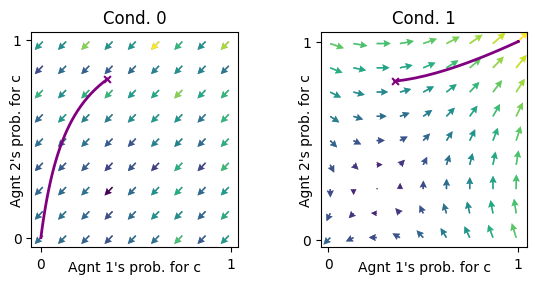

In [46]:
pc00, pc01, pc10, pc11 = 0.35, 0.35, 0.8, 0.8
X = [[[pc00, 1-pc00],     #initial policy to visulize learning trajectory
      [pc01, 1-pc01]], 
     [[pc10, 1-pc10], 
      [pc11, 1-pc11]]] 
X = np.array(X)
xtraj, fixedpointreached = mae_fullObs.trajectory(X)

x = ([0], [0,1], [0])  # Plotting on the x-axis the [0]'s agents probability in both observations [0,1] to cooprate [0]
y = ([1], [0,1], [0])  # Plotting on the y-axis the [1]'s agents probability in both observations [0,1] to cooprate [0]
ax = fp.plot_strategy_flow(mae_fullObs, x, y, flowarrow_points = np.linspace(0.01 ,0.99, 9), NrRandom=16)
fp.plot_trajectories([xtraj], x, y, cols=['purple'], axes=ax)

### Testing MultipleObsSocialDilemma under partial homogeneous observability conditions:

for agent  0
confidence is , 0.5
2 2 2
for agent  1
confidence is , 0.5
2 2 2


array([<Axes: title={'center': 'Cond. 0'}, xlabel="Agnt 1's prob. for c", ylabel="Agnt 2's prob. for c">,
       <Axes: title={'center': 'Cond. 1'}, xlabel="Agnt 1's prob. for c", ylabel="Agnt 2's prob. for c">],
      dtype=object)

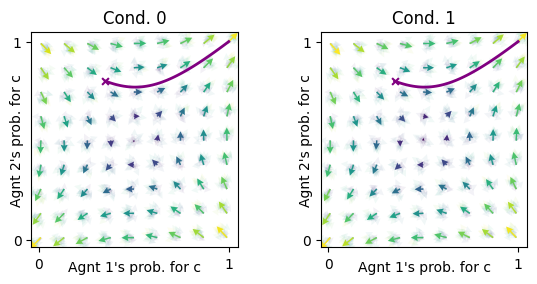

In [48]:
env_randObs = MultipleObsSocialDilemma(rewards=[5, 5], temptations=[6, 2], suckers_payoffs=[-1, -1], punishments=[0, 0], pC=0.5, observation_opacity=[0.5, 0.5])
mae_randObs = POstratAC(env=env_randObs, learning_rates=0.1, discount_factors=0.9)
xtraj, fixedpointreached = mae_randObs.trajectory(X)

ax = fp.plot_strategy_flow(mae_randObs, x, y, flowarrow_points = np.linspace(0.01 ,0.99, 9), NrRandom=16)
fp.plot_trajectories([xtraj], x, y, cols=['purple'], axes=ax)

In [50]:
env_randObs.O

array([[[0.5, 0.5],
        [0.5, 0.5]],

       [[0.5, 0.5],
        [0.5, 0.5]]])

### Testing MultipleObsSocialDilemma under partial heterogeneous observability conditions:

### Testing the history aspects:

In [49]:
from pyCRLD.Environments.HistoryEmbedding import HistoryEmbedded

env_fullObs = MultipleObsSocialDilemma(rewards=[5,5], temptations=[6,2], suckers_payoffs=[-1,-1], punishments=[0, 0], pC=0.5, observation_opacity=[0,1])
env_fullObs.Sset = ['.', '.']
memo1pd = HistoryEmbedded(env_fullObs, h=(1,1,1))
# memo1pd.Sset

for agent  0
confidence is , 0
2 2 2
for agent  1
confidence is , 1
2 2 2


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()